In [1]:
# Importing the libraries we will need
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

In [2]:
# Setting our working directory 
os.chdir("C:/Users/Home/Desktop/Guided_project")

# Introduction

In this project, we practice SQL skills by using a database of the Chinook record store.

Specifically, we will use SQLite to explore the Chinook database ([downloaded here](https://www.sqlitetutorial.net/sqlite-sample-database/))  and help managers make business decisions.

The business questions we will answer in this project are the following:

- What are the most popular music genres sold in the USA?
- Who's the guy? Looking at sales agents performances
- How good are sales by country?
- What do customers prefer to buy, full albums or individuals tracks?

Note: I developed this project as part of the "SQL intermediate: Table relations and joins" course of [Dataquest](https://app.dataquest.io/course/sql-joins-relations).

# Creating helper functions

First, let's create some helper functions to make our work easier.

We will create two functions:

- `run_query`, which help us run our SQL queries quicker
- `show_tables`, which displays a list of the tables in our database, so that we can check the state of the database as we work

But before that, let's connect to the Chinook database.

In [3]:
# Connecting to the chinook database
sqlite3.connect("chinook.db")

In [4]:
# Creating the run_query function to run SQL queries easier
def run_query(q):
    with sqlite3.connect("chinook.db") as conn:
        return pd.read_sql(q,conn)

In [5]:
# Creating the show_tables function to display the tables of our database
def show_tables():
    return run_query("SELECT name, type FROM sqlite_master WHERE type IN ('table')")

Let's take a look at the tables of our database

In [6]:
show_tables()

,name,type
0,albums,table
1,sqlite_sequence,table
2,artists,table
3,customers,table
4,employees,table
5,genres,table
6,invoices,table
7,invoice_items,table
8,media_types,table
9,playlists,table


As we can see, there are 12 tables of music/artist content (e.g. `albums` and `artists`), customers information and purchases (e.g. `invoices`) 

# What are the most popular music genres sold in the USA?

Suppose that the Chinook record store has just signed a deal with a new record label.

The record label has four albums and we have to select two of them to add to the Chinook record store. All albums are by artists that don't have music tracks in the Chinook record store. Furthermore, the record label is specialized in artists from the USA and have given Chinook some money to advertise in the USA. Therefore, the record label wants to know which music genres sell the best in the USA.

The artists and genres of the four albums the record label has available are the following:

- Regal: Hip-Hop
- Red tone: Punk
- Meteor and the girls: Pop
- Slim Jim Bites: Blues

Let's find out which of these four music genres are sold more frequently in the Chinook record store among USA customers so that the new record label decides which two albums to make available for sale in the Chinook record store.

In [7]:
genres_popularity=run_query('''
            WITH genres_purchased AS
                (SELECT 
                    c.country,
                    ii.invoiceID, 
                    ii.quantity, 
                    t.trackID, 
                    t.genreID, 
                    g.name 
                FROM customers c
                INNER JOIN invoices i ON i.customerID=c.customerID
                INNER JOIN invoice_items ii ON ii.invoiceID=i.invoiceID
                INNER JOIN tracks t ON t.trackID=ii.trackID
                INNER JOIN genres g ON g.genreID=t.genreID),
            
            genres_purchased_USA AS
                (SELECT
                    * 
                FROM genres_purchased
                WHERE country='USA')
            
            
            SELECT
                name genre,
                COUNT(invoiceID) soundtrack_purchases,
                ROUND(CAST(COUNT(name) AS FLOAT)/(SELECT COUNT(name) FROM genres_purchased_USA),2) soundtrack_purchases_percentage                         
                FROM genres_purchased_USA
                GROUP BY name
                ORDER BY soundtrack_purchases DESC;
                ''')
genres_popularity.head(20)

,genre,soundtrack_purchases,soundtrack_purchases_percentage
0,Rock,157,0.32
1,Latin,91,0.18
2,Metal,64,0.13
3,Alternative & Punk,50,0.10
4,Jazz,22,0.04
5,Blues,15,0.03
6,TV Shows,14,0.03
7,R&B/Soul,12,0.02
8,Classical,8,0.02
9,Comedy,8,0.02


Let's plot the result of our SQL query.

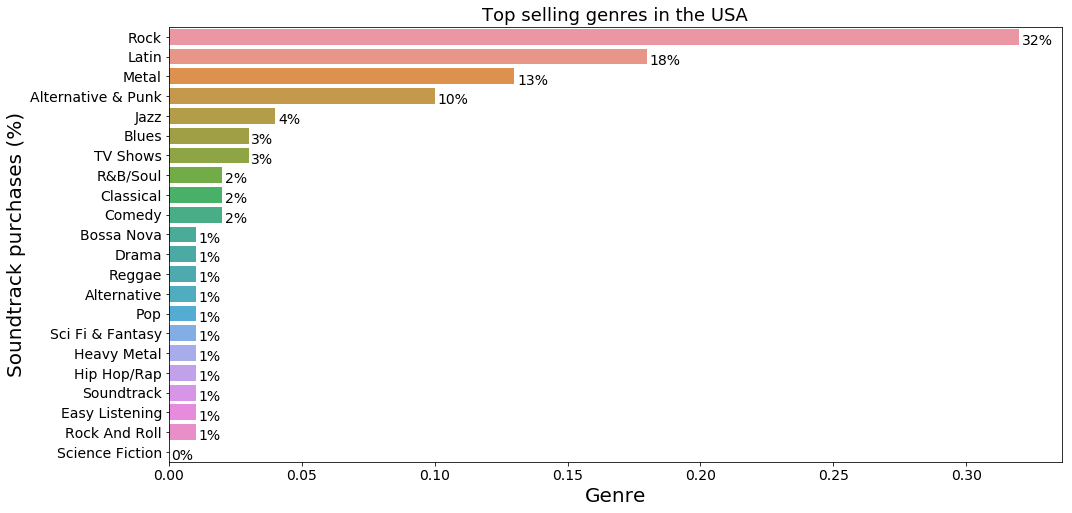

In [8]:
plt.figure(figsize=(16,8))
ax=sns.barplot(x=genres_popularity.soundtrack_purchases_percentage, y=genres_popularity.genre, orient="h")
ax.tick_params(axis="both", labelsize=14)
ax.set_xlabel("Genre", fontsize=20)
ax.set_ylabel("Soundtrack purchases (%)", fontsize=20)
ax.set_title("Top selling genres in the USA", fontsize=18)

for i,p in zip(ax.patches,genres_popularity.loc[:,"soundtrack_purchases_percentage"]):
    _x=i.get_x()+i.get_width()+float(0.001)
    _y=i.get_y()+i.get_height()
    value="{}%".format(int(p*100))
    ax.text(_x,_y,value,fontsize=14,ha="left")
plt.show()

The music genres of the four albums the record label has available are hip-hop, punk, pop, and blues. As we can see, of these four genres, from most to least popular, are punk (Alternative & Punk chinook genre category), blues, pop, and hip-hop.

Therefore, based on what data is showing, we recommend that Red Tone (punk) and Slim Jim Bites (blues) albums are should make available for sale in the Chinook record store, as punk and blues are more popular than pop and hip-hop music.

In [9]:
show_tables()

,name,type
0,albums,table
1,sqlite_sequence,table
2,artists,table
3,customers,table
4,employees,table
5,genres,table
6,invoices,table
7,invoice_items,table
8,media_types,table
9,playlists,table


# Who's the guy?
## Looking at sales agents performances

Now, let's take a look at the Chinook record store's employees. Who's the best seller?

Let's write a SQL query to find out who's the guy.

In [10]:
sellers=run_query('''
            WITH employee_invoices AS
            (SELECT
                e.employeeID sales_agent_ID,
                e. firstName || " " || e.lastName sales_agent,
                e.hireDate hire_date,
                i.invoiceDate invoice_date,
                i.total
            FROM employees e
            INNER JOIN customers c ON c.supportrepID=e.employeeID
            INNER JOIN invoices i ON i.customerID=c.customerID),
            
            last_invoices AS
            (SELECT
                sales_agent_ID,
                sales_agent,
                MAX(invoice_date) latest_invoice
            FROM employee_invoices
            GROUP BY sales_agent)                                
            

            SELECT 
                ei.sales_agent_ID,
                ei.sales_agent,
                ei.hire_date,
                li.latest_invoice,
                SUM(total) total_sales
            FROM employee_invoices ei 
            INNER JOIN last_invoices li ON li.sales_agent_ID=ei.sales_agent_ID
            GROUP BY ei.sales_agent
            ORDER BY total DESC
            ''')

sellers["hire_date"]=pd.to_datetime(sellers["hire_date"],format="%Y-%m-%d")
sellers["latest_invoice"]=pd.to_datetime(sellers["latest_invoice"],format="%Y-%m-%d")
sellers

,sales_agent_ID,sales_agent,hire_date,latest_invoice,total_sales
0,3,Jane Peacock,2002-04-01,2013-12-22,833.04
1,4,Margaret Park,2003-05-03,2013-12-09,775.40
2,5,Steve Johnson,2003-10-17,2013-12-05,720.16


## Jane Peacock is the winner!

However, Jane has been hired for a longer time than Margaret and Steve Johnson. So it's natural that she has sold more than her two colleagues.

# How good are sales by country?

Now, let's compare sales performance among countries.

Specifically, we want to know for each country:

- Total number of customers
- The total value of sales
- Average order value

As many countries have only one single customer, we will group all single-customer countries in the category `Other`.

In [11]:
sales_per_country=run_query('''
WITH data_per_country AS(
    SELECT
    CASE
        WHEN (
            SELECT COUNT(*) 
            FROM customers
            WHERE country=c.country) =1 THEN "Other"
        ELSE c.country
        END AS country,
    c.customerID,
    ii.*  
FROM customers c
INNER JOIN invoices i ON i.customerID=c.customerID
INNER JOIN invoice_items ii ON ii.invoiceID=ii.invoiceID
ORDER BY country
)

SELECT
    country,
    total_customers,
    total_sales,
    avg_order
    FROM (
        SELECT
            country,
            COUNT (DISTINCT customerID) total_customers,
            ROUND(SUM(unitPrice),2) total_sales,
            ROUND(SUM(unitPrice)/COUNT(DISTINCT invoiceID),2) avg_order,
            CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort            
        FROM data_per_country
        GROUP BY country
        ORDER BY sort, total_sales DESC)
''')
sales_per_country

,country,total_customers,total_sales,avg_order
0,USA,13,211902.6,514.33
1,Canada,8,130401.6,316.51
2,Brazil,5,81501.0,197.82
3,France,5,81501.0,197.82
4,Germany,4,65200.8,158.25
5,United Kingdom,3,48900.6,118.69
6,Czech Republic,2,32600.4,79.13
7,Portugal,2,32600.4,79.13
8,India,2,30271.8,73.48
9,Other,15,244503.0,593.45


## Visualizing sales by country

Now that we have our data, we've been asked to create a series of visualizations that communicate our findings. Then, we will make recommendations on which countries may have potential for growth. This way, the Chinook marketing team can focus on such countries to create new advertising campaigns.

In [16]:
list(country_metrics.index)

['USA',
 'Canada',
 'Brazil',
 'France',
 'Germany',
 'United Kingdom',
 'Czech Republic',
 'Portugal',
 'India',
 'Other']

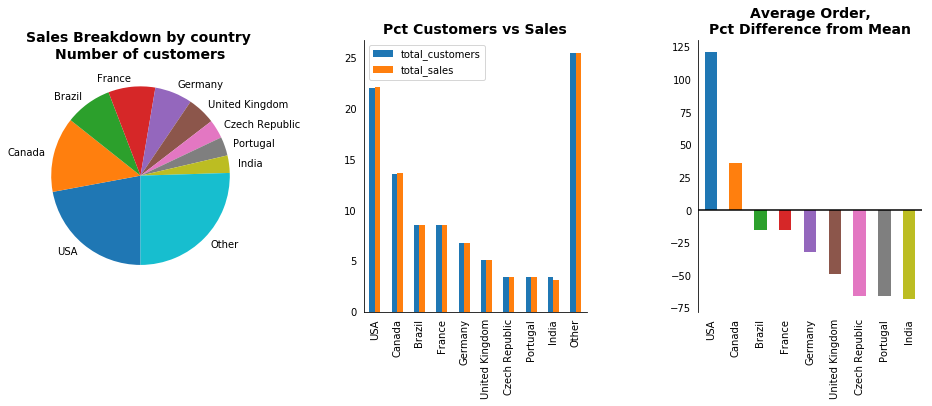

In [23]:
country_metrics=sales_per_country.set_index("country", drop=True)

fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(16,5))
ax1,ax2,ax3=axes.flatten()
fig.subplots_adjust(hspace=1,wspace=0.5)
ax.set_prop_cycle(plt.cycler('color', plt.cm.Accent(np.linspace(0, 1, 10))))

# Left plot
sales_breakdown=country_metrics["total_sales"].copy().rename("")
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    fontsize=10,
    wedgeprops={"linewidth":0}
)
ax1.set_title("Sales Breakdown by country \nNumber of customers",fontweight="bold", size=14) 


# Middle plot
cvd_cols=["total_customers","total_sales"]
cust_vs_dollars=country_metrics[cvd_cols].copy()
cust_vs_dollars.index.name=''
for c in cvd_cols:
    cust_vs_dollars[c]/=cust_vs_dollars[c].sum()/100
cust_vs_dollars.plot.bar(
    ax=ax2,
    fontsize=10
)
ax2.set_title("Pct Customers vs Sales",fontweight="bold", size=14) 
ax2.tick_params(top=False, right=False, left=False, bottom=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


#Right plot
avg_order=country_metrics["avg_order"].copy()
avg_order.index.name=""
difference_from_avg=avg_order*100/avg_order.mean()-100
difference_from_avg.drop("Other",inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    title="Average Order,\nPct Difference from Mean",
    fontsize=10
)
ax3.set_title("Average Order,\nPct Difference from Mean",fontweight="bold", size=14) 
ax3.tick_params(top=False, right=False, left=False, bottom=False)
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)  

plt.show()

The USA is the largest source of revenue for the Chinook record store, whereas India, despite its huge population, is the smallest source of revenue. Together, all countries with only one single customer (Others category) represent the largest portion of revenue.

Total sales by country seem intimately related with the number of customers in each country, indicating customers behave similarly among countries.

USA and Canada seem well-established markets, and marketing efforts should be made in Brazil, France, and Germany, as they are right after the USA and Canada.

However, as this analysis is based on small samples, these results deserve caution. It is best to start small marketing campaigns in these countries and then collect more data to evaluate its effectiveness.

# What do customers prefer to buy, full albums or individuals tracks?

The Chinook record store allows customers to purchase either full albums or individual tracks. If a customer wants to buy a full album and individuals tracks, then two invoices will be generated, one for the album and another one for the tracks purchased individually.

Let's suppose management is considering changing the purchasing strategy to save money. The idea is that Chinook purchases only the albums' most popular tracks from the record companies, instead of purchasing the full albums.

To help management decide whether or not to change the purchasing strategy, we have been asked to find out which percentage of purchases are of individual tracks vs full albums.

In [13]:
# SQL query to find out which percentage of purchases are individual tracks vs full albums

run_query('''
WITH invoice_first_track AS
    (
    SELECT
        invoiceID invoice_ID,
        MIN(trackID) first_track_ID
    FROM invoice_items
    GROUP BY invoice_ID
    )
    
SELECT
    album_purchase,
    COUNT(invoice_ID) number_of_invoices,
    CAST(COUNT(invoice_ID) AS FLOAT)/(SELECT COUNT(*) FROM invoices) percentage
    
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                (
                SELECT t.trackID FROM tracks t
                WHERE t.albumID=(
                                SELECT t2.albumID FROM tracks t2
                                WHERE t2.trackID=first_track_ID
                                ) 
                EXCEPT
            
            
                SELECT ii.trackID FROM invoice_items ii
                WHERE ii.invoiceID=ifs.invoice_ID   
                                                         
                ) IS NULL
            
                AND
            
                (                        
                SELECT ii.trackID FROM invoice_items ii
                WHERE ii.invoiceID=ifs.invoice_ID   
            
                EXCEPT
            
            
                SELECT t.trackID FROM tracks t
                WHERE t.albumID=(
                                SELECT t2.albumID FROM tracks t2
                                WHERE t2.trackID=ifs.first_track_ID
                                ) 
            
                ) IS NULL
            
                    THEN "yes"
                    ELSE "no"
        
        END AS "album_purchase"
    FROM invoice_first_track ifs
    )

GROUP BY album_purchase
''')
   

,album_purchase,number_of_invoices,percentage
0,no,410,0.995146
1,yes,2,0.004854


As we can see, almost 100% of purchases are of individual tracks rather than full albums. 
Therefore, it doesn't seem a good idea Chinook start purchasing only the albums' most popular tracks as customers seem selective on their tracks choices. 